In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import MDAnalysis as mda
from MDAnalysis.coordinates.memory import MemoryReader
from MDAnalysis.transformations import wrap 
from MDAnalysis.transformations.boxdimensions import set_dimensions


my_cmap = ListedColormap(sns.color_palette('pastel').as_hex())

# Functions defined

In [30]:
def pi_centrer(coords,weights,box_min, box_width):

    frac_coords = (coords - box_min) / box_width
    theta = frac_coords * (2 * np.pi) 
    xi = np.cos(theta)
    zeta = np.sin(theta)
    xi_bar = np.average(xi,weights=weights)
    zeta_bar = np.average(zeta,weights=weights)
    theta_bar = np.arctan2(-zeta_bar, -xi_bar) + np.pi
    new_s_coords = (theta_bar) / (2 * np.pi)
    new_s_coords = new_s_coords*box_width + box_min

    return new_s_coords

In [31]:
def xi_zeta_calc(masses,coords):
    box_min = 0
    box_width = 20
    frac_coords = (coords - box_min) / box_width 
    theta = frac_coords * (2 * np.pi) + np.pi
    xi = np.cos(theta)
    zeta = np.sin(theta)
    return xi, zeta

In [32]:
def xi_zeta_bar_calc(masses,coords):
    box_min = 0
    box_width = 20
    frac_coords = (coords - box_min) / box_width
    theta = frac_coords * (2 * np.pi) + np.pi
    xi = np.cos(theta)
    zeta = np.sin(theta)    
    xi_bar = np.average(xi,weights=masses)
    zeta_bar = np.average(zeta,weights=masses)
    theta_bar = np.arctan2(-zeta_bar, -xi_bar) 
    return xi_bar, zeta_bar, theta_bar

In [33]:
def test_pi_centrer(masses,x_coords):

    box_min = 0
    box_max = 20
    box_width = box_max - box_min
    particles = len(masses)

    yz = np.zeros((2, particles))
    x_coords = x_coords % 20
    coords = np.concatenate((x_coords[np.newaxis, :], yz), axis=0).T


    u = mda.Universe.empty(particles ,trajectory = True)
    u.add_TopologyAttr('masses',masses)
    #u.add_TopologyAttr('dimensions', np.array[20,20,20,90,90,90])
    u.transfer_to_memory()
    #u.add_TopologyAttr('bonds', )



    reader = MemoryReader(coords)
    u.trajectory = reader
    dim = np.array([box_max, box_max, box_max, 90, 90, 90])
    transform1 = mda.transformations.boxdimensions.set_dimensions(dim)
    transform2 = wrap(u.atoms)
    workflow  = [transform1,transform2]
    u.trajectory.add_transformations(*workflow)

    u.add_bonds([tuple(range(i, i+2)) for i in range(0, particles-1)])

    u.atoms.unwrap()
    MDA_com = u.atoms.center_of_mass()[0]
    com_pi = pi_centrer(coords[:,0], masses,box_min,box_width)
    corrected_com = (np.average(((coords[:,0] - (com_pi + 0.5*box_width) ) % box_max), weights = masses) + (com_pi + 0.5*box_width)) % box_max
    wrapped = ((coords[:,0] - (com_pi + 0.5*box_width) ) % box_max)

    return MDA_com, com_pi, corrected_com 

# Plotting

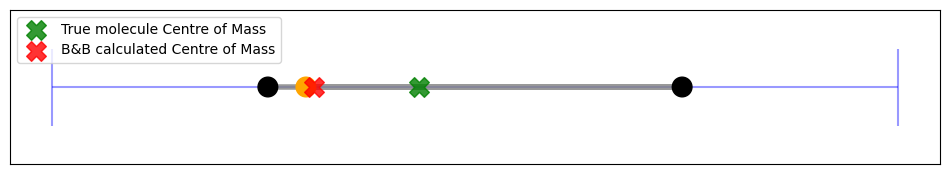

In [34]:

particles = 3

coords = np.array([5.1,14.9,6])
masses =np.array([1,1,1])

fig,ax = plt.subplots(1,1,figsize = (12,2))


# draw lines
xmin = 0
xmax = 20
y1 = 0
height = 1

ax.set_xlim(-1,21)
ax.set_ylim(-1,1)
ax.hlines(y1, xmin, xmax, color = 'blue', alpha = 0.4)
ax.vlines(xmin, y1 - height / 2., y1 + height / 2.,color = 'blue', alpha = 0.4)
ax.vlines(xmax, y1 - height / 2., y1 + height / 2.,color = 'blue', alpha = 0.4)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])

l_set = 4
s_set = 200
marker_set = 20


ax.scatter(coords,np.zeros(particles), s = s_set, color = ['black','black','orange'], zorder=8)#size = np.sqrt(masses)*100, color = 'orange')
ax.plot(coords,np.zeros(particles), color = 'grey', alpha = 0.8, linewidth = l_set)
ax.scatter(np.average(coords, weights=masses),0, s=s_set, color = 'green', marker = 'X', label = 'True molecule Centre of Mass',zorder=10, alpha=0.8)


mda_com, com_pi, corrected_com = test_pi_centrer(masses,coords)


ax.scatter(com_pi,0, s=s_set, color = 'red', marker = 'X', label = 'B&B calculated Centre of Mass',zorder=10, alpha=0.8)

ax.legend(loc = 'upper left')


In [35]:
from matplotlib.patches import Arc

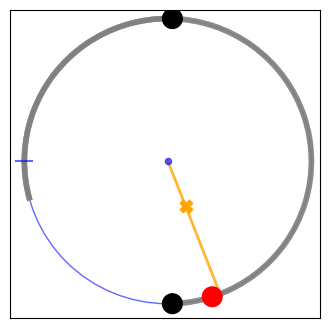

In [36]:


fig,ax = plt.subplots(figsize = (4,4))

ax.set_xlim(-1.1,1.06)
ax.set_ylim(-1.1,1.06)

ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])


circle = plt.Circle((0, 0), 1, fill=False,color = 'blue', alpha = 0.6)  # `fill=False` for an unfilled circle
ax.add_artist(circle)
ax.axhline(0, 0.02,0.07, color = 'blue', alpha = 0.6)


xi, zeta = xi_zeta_calc(masses,coords)
ax.scatter(xi,zeta, color=['black','black','red'], s = 200, zorder=10)
ax.scatter(0,0, color='blue', s = 20, zorder=10, alpha = 0.6)

xi_bar, zeta_bar, theta_bar = xi_zeta_bar_calc(masses,coords)

xi_calc,zeta_calc = xi_zeta_calc(masses,com_pi)

# Add arcs between points
for i in range(len(xi)-1):
    for j in range(i , len(xi)-1):
        angle1 = np.degrees(np.arctan2(zeta[i], xi[i]))
        angle2 = np.degrees(np.arctan2(zeta[j], xi[j]))
        start_angle = min(angle1, angle2)
        end_angle = max(angle1, angle2)

        # Add an arc between the two points
        arc = Arc((0, 0), 2, 2, theta1=start_angle, theta2=196, color='gray', alpha=0.7, linewidth =l_set, zorder=1)
        ax.add_patch(arc)


ax.scatter(xi_bar,zeta_bar, color='orange', marker = 'X', s = 80, zorder=10)
ax.plot([0,xi_calc],[0,zeta_calc], color = 'orange', alpha = 0.8, linewidth = 2)


In [37]:
com_pi

6.186345202725536

In [38]:
corrected_com

8.666666666666664

In [39]:
pseudo_coords = (coords - (com_pi + 0.5*20)) % 20

In [40]:
np.average(pseudo_coords, weights=masses)

12.480321463941129

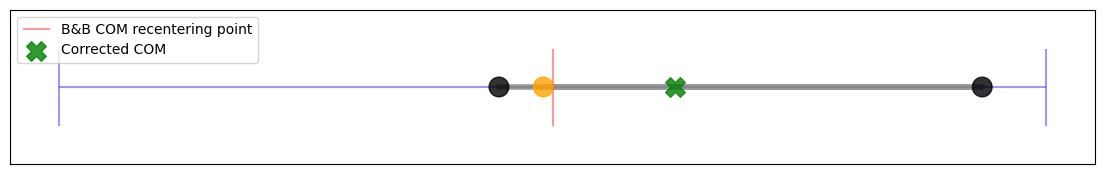

In [44]:
fig,ax = plt.subplots(figsize = (14,2))

ax.set_xlim(-1,21)
ax.set_ylim(-1,1)
ax.hlines(y1, xmin, xmax, color = 'blue', alpha = 0.4)
ax.vlines(xmin, y1 - height / 2., y1 + height / 2.,color = 'blue', alpha = 0.4)
ax.vlines(xmax, y1 - height / 2., y1 + height / 2.,color = 'blue', alpha = 0.4)
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])


ax.scatter(pseudo_coords,np.zeros(particles), s = s_set, color = ['black','black','orange'], zorder=8, alpha = 0.8)#size = np.sqrt(masses)*100, color = 'orange')
ax.plot(pseudo_coords,np.zeros(particles), color = 'grey', alpha = 0.8, linewidth = l_set)
ax.vlines(10, y1 - height / 2., y1 + height / 2.,color = 'red', alpha = 0.4, label = 'B&B COM recentering point')
ax.scatter(np.average(pseudo_coords, weights=masses),0, s=s_set, color = 'green', marker = 'X', label = 'Corrected COM',zorder=10, alpha=0.8)




ax.legend(loc = 'upper left')

In [42]:
np.average(pseudo_coords, weights=masses)

12.480321463941129

In [43]:
10

10